# Merge External Datasets

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import types as T
from pyspark.sql.types import DoubleType

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path
import shutil
import pyarrow as pa
import pyarrow.dataset as ds
import pyarrow.parquet as pq
from pyspark.sql.window import Window
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import glob

## Starting a Pyspark

In [2]:
spark = (
    SparkSession.builder.appName("BNPL Merge Write")
    .config("spark.driver.memory", "12g")          
    .config("spark.executor.memory", "12g")      
    .config("spark.sql.shuffle.partitions", "200")
    .config("spark.sql.adaptive.enabled", "true")
    .config("spark.sql.files.maxPartitionBytes", "64m")
    .config("spark.driver.extraJavaOptions", "-Djava.security.manager=allow")
    .config("spark.executor.extraJavaOptions", "-Djava.security.manager=allow") 
    .getOrCreate()
)

25/10/03 18:16:42 WARN Utils: Your hostname, MacBook-Pro-3.local resolves to a loopback address: 127.0.0.1; using 192.168.0.11 instead (on interface en0)
25/10/03 18:16:42 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/03 18:16:43 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Loading Data

In [ ]:
# Paths
RAW_EXT = Path("../data/raw/external_dataset")
CUR = Path("../data/curated")

In [4]:
SRC_TX = CUR / "all_given_data.parquet"           # ORIGINAL (timestamps ns)
DST_TX = CUR / "all_given_data_us.parquet"        # CONVERTED (timestamps us)

print("SRC exists? ", SRC_TX.exists(), SRC_TX)
print("DST exists? ", DST_TX.exists(), DST_TX)

# All given datasets
def convert_parquet_ns_to_us(src: Path, dst: Path):
    # Remove any old output
    if dst.exists():
        shutil.rmtree(dst) if dst.is_dir() else dst.unlink()
    dataset = ds.dataset(str(src), format="parquet")
    table = dataset.to_table()

    pq.write_table(
        table,
        where=str(dst),
        coerce_timestamps="us",
        allow_truncated_timestamps=True,
        use_deprecated_int96_timestamps=False
    )
    print(f"Rewrote\n  {src}\n→ {dst}")

convert_parquet_ns_to_us(SRC_TX, DST_TX)
given_dataset = spark.read.parquet(str(DST_TX))

SRC exists?  True data/curated/all_given_data.parquet
DST exists?  False data/curated/all_given_data_us.parquet
Rewrote
  data/curated/all_given_data.parquet
→ data/curated/all_given_data_us.parquet


In [5]:
consumer_df = (spark.read.option("header", True).option("inferSchema", True)
    .csv(str(CUR / "consumer_sa2.csv"))
)

In [6]:
# External Datasets
gcp = (
    spark.read.option("header", True).option("inferSchema", True)
    .csv(str(CUR / "gcp_merged_cleaned.csv"))
)

wpp = (
    spark.read.option("header", True).option("inferSchema", True)
    .csv(str(CUR / "WPP_cleaned.csv"))
)
if "Unnamed: 0" in wpp.columns:
    wpp = wpp.drop("Unnamed: 0")
    wpp = wpp.drop("_c0")

apra_seifa = (
    spark.read.option("header", True).option("inferSchema", True)
    .csv(str(CUR / "apra_seifa_imputed.csv"))
)

for c in ["__key_x", "__key_y"]:
    if c in apra_seifa.columns:
        apra_seifa = apra_seifa.drop(c)

In [7]:
# (column lists like pandas .columns — just to echo)
print("given_dataset columns:", given_dataset.columns)
print("gcp columns:", gcp.columns)
print("wpp columns:", wpp.columns)
print("apra_seifa columns:", apra_seifa.columns)

given_dataset columns: ['user_id', 'merchant_abn', 'dollar_value', 'order_id', 'order_datetime', 'consumer_id', 'transaction_count', 'total_spend', 'unique_merchants', 'avg_spend', 'consumer_fraud_prob_avg', 'consumer_name', 'address', 'state', 'postcode', 'gender', 'SA2_code', 'SA2_name', 'is_po_box', 'merchant_name', 'tags', 'categories', 'type', 'take_rate', 'order_count', 'total_sales', 'avg_order_value', 'unique_consumers', 'repeat_consumers', 'repurchase_rate']
gcp columns: ['SA2_code', 'SA2_name', 'state_code', 'state_name', 'geometry', 'median_weekly_personal_income', 'household_personal_gap', 'dependency_ratio', 'pct_youth', 'pct_seniors', 'unemployment_rate', 'full_time_share', 'part_time_share']
wpp columns: ['_c0', 'SA2_code', 'Incorporated', 'Unincorporated', 'Enterprises with no Employees', 'Enterprises with not stated Employees', 'high_skill_occ', 'med_skill_occ', 'low_skill_occ']
apra_seifa columns: ['SA2_code', 'irsad', 'irsd', 'ier', 'ieo', 'ATMs', 'Bank_post', 'Branc

## Check Correlation of External Datasets with Given Datasets

### GCP with Consumer and Merchant

Merged shape (consumer_gcp): (13614672, 42)


25/10/03 18:17:21 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


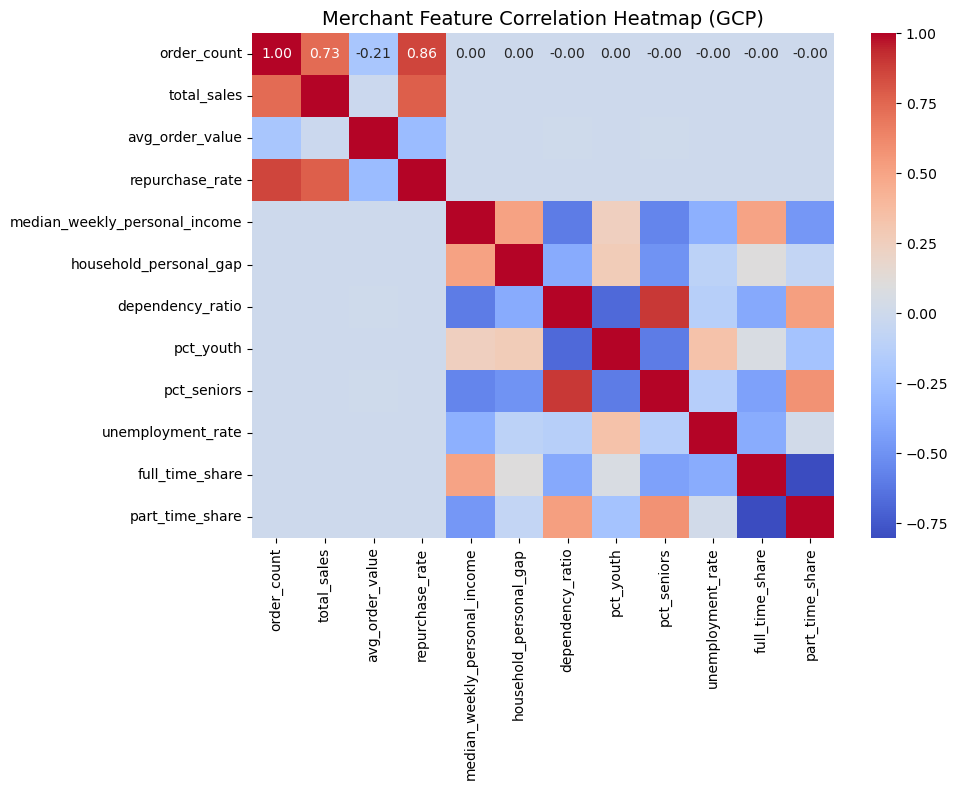

In [8]:
# Merge with GCP  (join on SA2_code)
gcp = gcp.withColumn("SA2_code", F.col("SA2_code").cast("string"))
consumer_gcp = given_dataset.join(gcp, on="SA2_code", how="left")
print("Merged shape (consumer_gcp):", (consumer_gcp.count(), len(consumer_gcp.columns)))

# Correlation Heatmap: Merchant (GCP)
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

merchant_features = [
    "merchant_fraud_weighted_spend",
    "merchant_fraud_prob_latest",
    "merchant_fraud_prob_avg",
    "order_count",
    "total_sales",
    "avg_order_value",
    "repurchase_rate",
    "median_weekly_personal_income","household_personal_gap","dependency_ratio",
    "pct_youth","pct_seniors","unemployment_rate","full_time_share","part_time_share"
]
cols_present = [c for c in merchant_features if c in consumer_gcp.columns]
df_m = consumer_gcp.select([F.col(c).cast("double").alias(c) for c in cols_present]).na.drop(subset=cols_present)

# (Optional speed-up for huge tables: sample)
rowcnt = df_m.count()
max_rows_for_corr = 2_000_000
if rowcnt > max_rows_for_corr:
    frac = max_rows_for_corr / rowcnt
    df_m = df_m.sample(withReplacement=False, fraction=frac, seed=42)

assembler_m = VectorAssembler(inputCols=cols_present, outputCol="features_vec")
df_m_vec = assembler_m.transform(df_m).select("features_vec")
corr_m = Correlation.corr(df_m_vec, "features_vec", method="pearson").collect()[0][0]
corr_m_np = np.array(corr_m.toArray())

plt.figure(figsize=(10, 8))
sns.heatmap(corr_m_np, annot=True, cmap="coolwarm", fmt=".2f",
            xticklabels=cols_present, yticklabels=cols_present)
plt.title("Merchant Feature Correlation Heatmap (GCP)", fontsize=14)
plt.tight_layout(); plt.show()

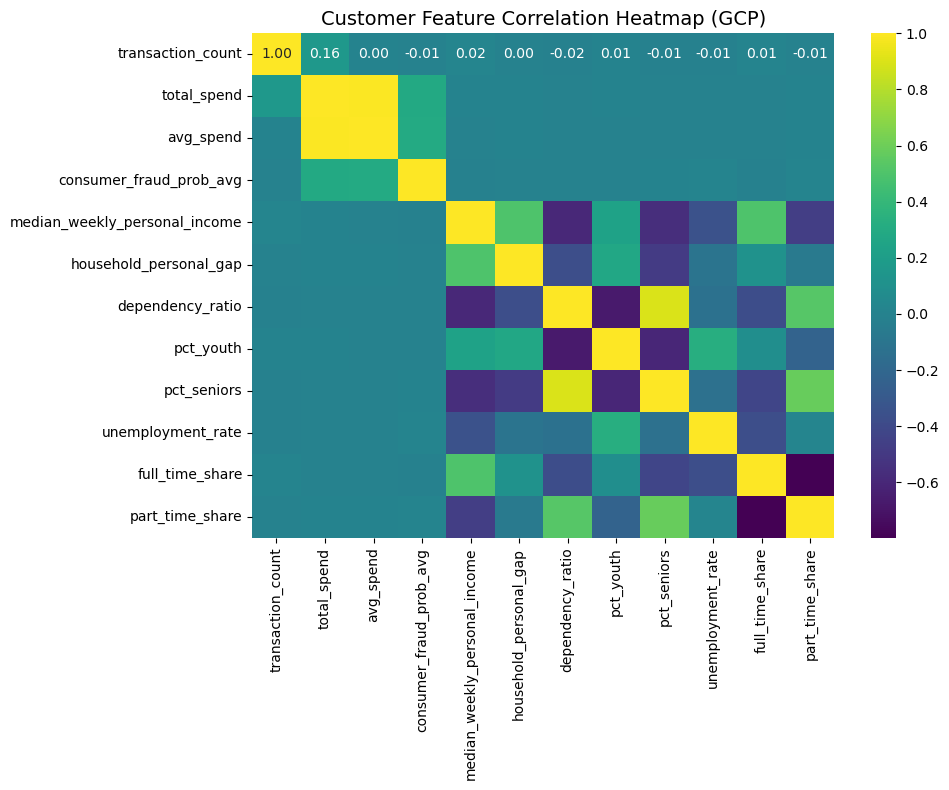

In [9]:
# Correlation Heatmap: Customer (GCP)
customer_features = [
    "transaction_count",
    "total_spend",
    "avg_spend",
    "consumer_fraud_prob_latest",
    "consumer_fraud_prob_avg",
    "consumer_fraud_weighted_spend",
    "median_weekly_personal_income","household_personal_gap","dependency_ratio",
    "pct_youth","pct_seniors","unemployment_rate","full_time_share","part_time_share"
]
cols_present_c = [c for c in customer_features if c in consumer_gcp.columns]
df_c = consumer_gcp.select([F.col(c).cast("double").alias(c) for c in cols_present_c]).na.drop(subset=cols_present_c)

rowcnt = df_c.count()
if rowcnt > max_rows_for_corr:
    frac = max_rows_for_corr / rowcnt
    df_c = df_c.sample(False, frac, seed=42)

assembler_c = VectorAssembler(inputCols=cols_present_c, outputCol="features_vec")
df_c_vec = assembler_c.transform(df_c).select("features_vec")
corr_c = Correlation.corr(df_c_vec, "features_vec", method="pearson").collect()[0][0]
corr_c_np = np.array(corr_c.toArray())

plt.figure(figsize=(10, 8))
sns.heatmap(corr_c_np, annot=True, cmap="viridis", fmt=".2f",
            xticklabels=cols_present_c, yticklabels=cols_present_c)
plt.title("Customer Feature Correlation Heatmap (GCP)", fontsize=14)
plt.tight_layout(); plt.show()

### WPP with Consumer and Merchant

Merged shape (consumer_wpp): (13614672, 38)


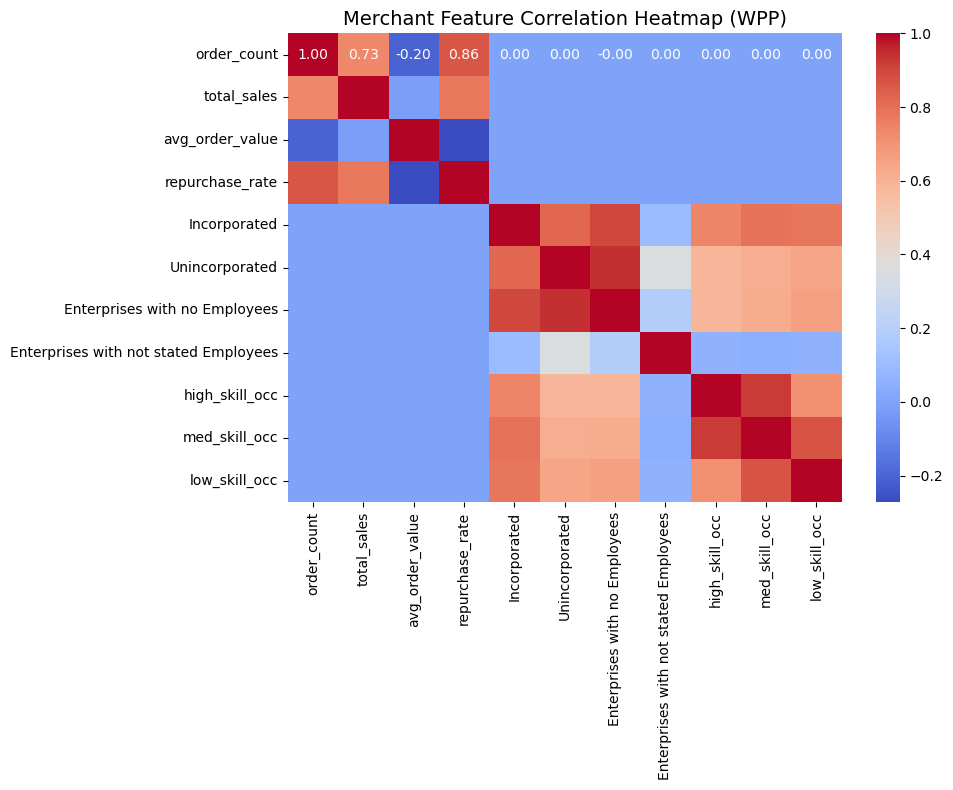

In [10]:
# Merge with WPP  (join on SA2_code)
wpp = wpp.withColumn("SA2_code", F.col("SA2_code").cast("string"))
consumer_wpp = given_dataset.join(wpp, on="SA2_code", how="left")
print("Merged shape (consumer_wpp):", (consumer_wpp.count(), len(consumer_wpp.columns)))

# Merchant (WPP)
merchant_features = [
    "merchant_fraud_weighted_spend",
    "merchant_fraud_prob_latest",
    "merchant_fraud_prob_avg",
    "order_count",
    "total_sales",
    "avg_order_value",
    "repurchase_rate",
    "Incorporated", "Unincorporated",
    "Enterprises with no Employees",
    "Enterprises with not stated Employees", "high_skill_occ",
    "med_skill_occ", "low_skill_occ"
]
cols_present = [c for c in merchant_features if c in consumer_wpp.columns]
df_m = consumer_wpp.select([F.col(c).cast("double").alias(c) for c in cols_present]).na.drop(subset=cols_present)

rowcnt = df_m.count()
if rowcnt > max_rows_for_corr:
    df_m = df_m.sample(False, max_rows_for_corr/rowcnt, seed=42)

assembler_m = VectorAssembler(inputCols=cols_present, outputCol="features_vec")
corr_m = Correlation.corr(assembler_m.transform(df_m).select("features_vec"), "features_vec").collect()[0][0]
corr_m_np = np.array(corr_m.toArray())

plt.figure(figsize=(10, 8))
sns.heatmap(corr_m_np, annot=True, cmap="coolwarm", fmt=".2f",
            xticklabels=cols_present, yticklabels=cols_present)
plt.title("Merchant Feature Correlation Heatmap (WPP)", fontsize=14)
plt.tight_layout(); plt.show()

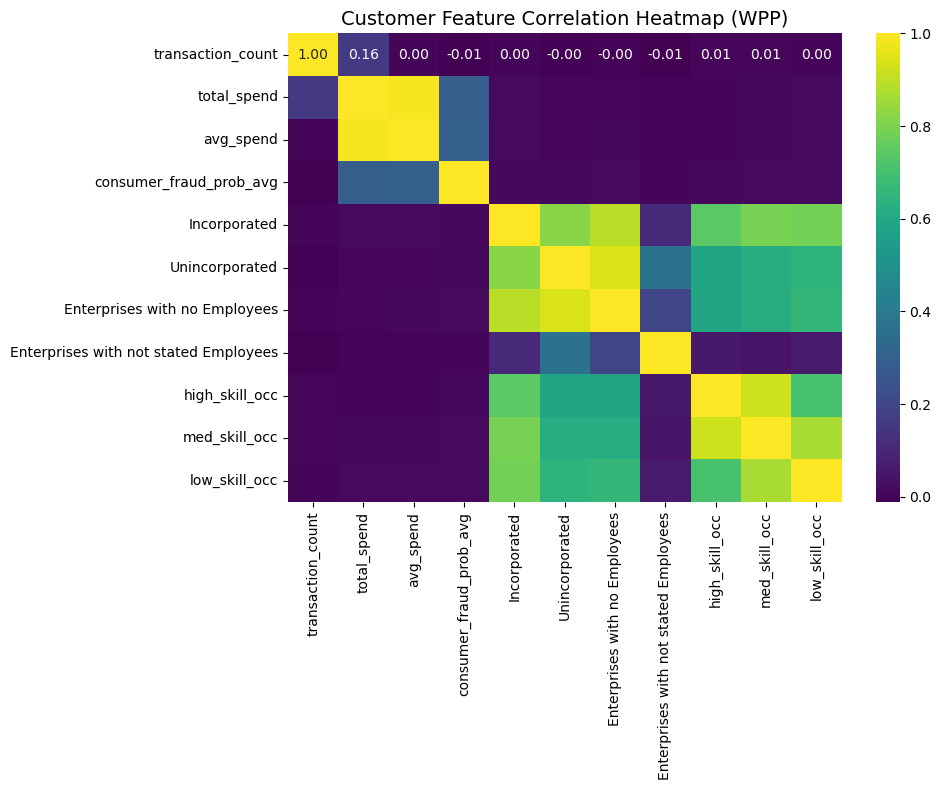

In [11]:
# Customer (WPP)
customer_features = [
    "transaction_count",
    "total_spend",
    "avg_spend",
    "consumer_fraud_prob_latest",
    "consumer_fraud_prob_avg",
    "consumer_fraud_weighted_spend",
    "Incorporated", "Unincorporated",
    "Enterprises with no Employees",
    "Enterprises with not stated Employees", "high_skill_occ",
    "med_skill_occ", "low_skill_occ"
]
cols_present = [c for c in customer_features if c in consumer_wpp.columns]
df_c = consumer_wpp.select([F.col(c).cast("double").alias(c) for c in cols_present]).na.drop(subset=cols_present)

rowcnt = df_c.count()
if rowcnt > max_rows_for_corr:
    df_c = df_c.sample(False, max_rows_for_corr/rowcnt, seed=42)

assembler_c = VectorAssembler(inputCols=cols_present, outputCol="features_vec")
corr_c = Correlation.corr(assembler_c.transform(df_c).select("features_vec"), "features_vec").collect()[0][0]
corr_c_np = np.array(corr_c.toArray())

plt.figure(figsize=(10, 8))
sns.heatmap(corr_c_np, annot=True, cmap="viridis", fmt=".2f",
            xticklabels=cols_present, yticklabels=cols_present)
plt.title("Customer Feature Correlation Heatmap (WPP)", fontsize=14)
plt.tight_layout(); plt.show()

### APRA SEIFA with Consumer and Merchant

Merged shape (consumer_apra_seifa): (13614672, 44)


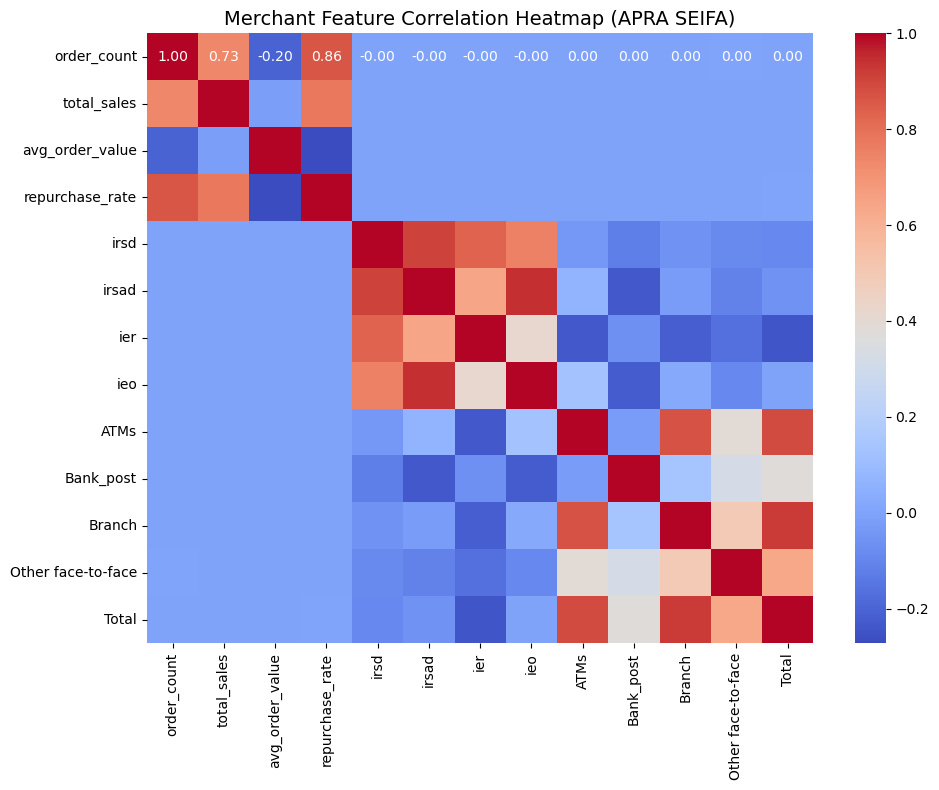

In [12]:
# Merge with APRA SEIFA  (join SA2_code == sa2code)
apra_seifa = apra_seifa.withColumn("SA2_code", F.col("SA2_code").cast("string"))
consumer_apra_seifa = given_dataset.join(
    apra_seifa, given_dataset["SA2_code"] == apra_seifa["SA2_code"], "left"
)
print("Merged shape (consumer_apra_seifa):", (consumer_apra_seifa.count(), len(consumer_apra_seifa.columns)))

# Merchant (APRA SEIFA)
merchant_features = [
    "merchant_fraud_weighted_spend",
    "merchant_fraud_prob_latest",
    "merchant_fraud_prob_avg",
    "order_count",
    "total_sales",
    "avg_order_value",
    "repurchase_rate",
    "irsd", "irsad", "ier", "ieo", "ATMs", "Bank_post", "Branch",
    "Other face-to-face", "Total"
]
cols_present = [c for c in merchant_features if c in consumer_apra_seifa.columns]
df_m = consumer_apra_seifa.select([F.col(c).cast("double").alias(c) for c in cols_present]).na.drop(subset=cols_present)

rowcnt = df_m.count()
if rowcnt > max_rows_for_corr:
    df_m = df_m.sample(False, max_rows_for_corr/rowcnt, seed=42)

assembler_m = VectorAssembler(inputCols=cols_present, outputCol="features_vec")
corr_m = Correlation.corr(assembler_m.transform(df_m).select("features_vec"), "features_vec").collect()[0][0]
corr_m_np = np.array(corr_m.toArray())

plt.figure(figsize=(10, 8))
sns.heatmap(corr_m_np, annot=True, cmap="coolwarm", fmt=".2f",
            xticklabels=cols_present, yticklabels=cols_present)
plt.title("Merchant Feature Correlation Heatmap (APRA SEIFA)", fontsize=14)
plt.tight_layout(); plt.show()

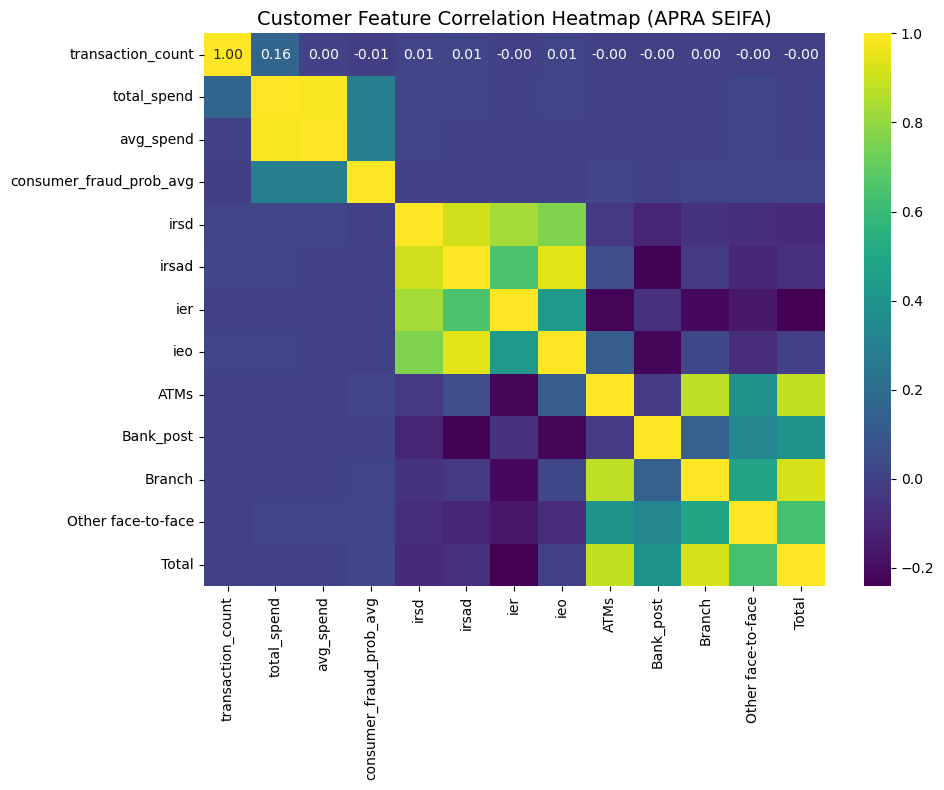

In [13]:
# Customer (APRA SEIFA)
customer_features = [
    "transaction_count",
    "total_spend",
    "avg_spend",
    "consumer_fraud_prob_latest",
    "consumer_fraud_prob_avg",
    "consumer_fraud_weighted_spend",
    "irsd", "irsad", "ier", "ieo", "ATMs", "Bank_post", "Branch",
    "Other face-to-face", "Total"
]
cols_present = [c for c in customer_features if c in consumer_apra_seifa.columns]
df_c = consumer_apra_seifa.select([F.col(c).cast("double").alias(c) for c in cols_present]).na.drop(subset=cols_present)

rowcnt = df_c.count()
if rowcnt > max_rows_for_corr:
    df_c = df_c.sample(False, max_rows_for_corr/rowcnt, seed=42)

assembler_c = VectorAssembler(inputCols=cols_present, outputCol="features_vec")
corr_c = Correlation.corr(assembler_c.transform(df_c).select("features_vec"), "features_vec").collect()[0][0]
corr_c_np = np.array(corr_c.toArray())

plt.figure(figsize=(10, 8))
sns.heatmap(corr_c_np, annot=True, cmap="viridis", fmt=".2f",
            xticklabels=cols_present, yticklabels=cols_present)
plt.title("Customer Feature Correlation Heatmap (APRA SEIFA)", fontsize=14)
plt.tight_layout(); plt.show()

## Check Feature Correlation among External Dataset

In [14]:
gcp_num = [
    "median_weekly_personal_income","household_personal_gap","dependency_ratio",
    "pct_youth","pct_seniors","unemployment_rate","full_time_share","part_time_share"
]
wpp_num = [
    "Incorporated","Unincorporated","Enterprises with no Employees",
    "Enterprises with not stated Employees","high_skill_occ","med_skill_occ","low_skill_occ"
]
apra_num = [
    "irsd","irsad","ier","ieo","ATMs","Bank_post","Branch",
    "Other face-to-face","Total","ATM_prop","Branch_prop","Bank_post_prop","Other_prop"
]

In [15]:
# Standardise keys and select needed columns
gcp2  = gcp.select("SA2_code", *gcp_num)
wpp2  = wpp.select("SA2_code", *wpp_num)
apra2 = apra_seifa.select(F.col("SA2_code"), *apra_num)

In [16]:
# Join to SA2-level external frame
ext = gcp2.join(wpp2, "SA2_code", "left").join(apra2, "SA2_code", "left")

In [17]:
# Collapse to one row per SA2
num_cols = gcp_num + wpp_num + apra_num
ext_sa2 = ext.groupBy("SA2_code").agg(*[F.avg(c).alias(c) for c in num_cols])

In [18]:
# Drop rows with nulls in any selected numeric column
ext_sa2 = ext_sa2.na.drop(subset=num_cols)

In [19]:
# Spearman = Pearson on ranks → rank each column via percent_rank()
ranked = ext_sa2
for c in num_cols:
    ranked = ranked.withColumn(f"r_{c}", F.percent_rank().over(Window.orderBy(F.col(c).asc_nulls_last())))

rank_cols = [f"r_{c}" for c in num_cols]

In [20]:
# Assemble and get correlation matrix (Pearson on ranks)
vec = VectorAssembler(inputCols=rank_cols, outputCol="features_vec").transform(ranked).select("features_vec")
corr_mat = Correlation.corr(vec, "features_vec", method="pearson").collect()[0][0].toArray()

25/10/03 18:18:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/10/03 18:18:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/10/03 18:18:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/10/03 18:18:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/10/03 18:18:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/10/03 18:18:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/10/03 1

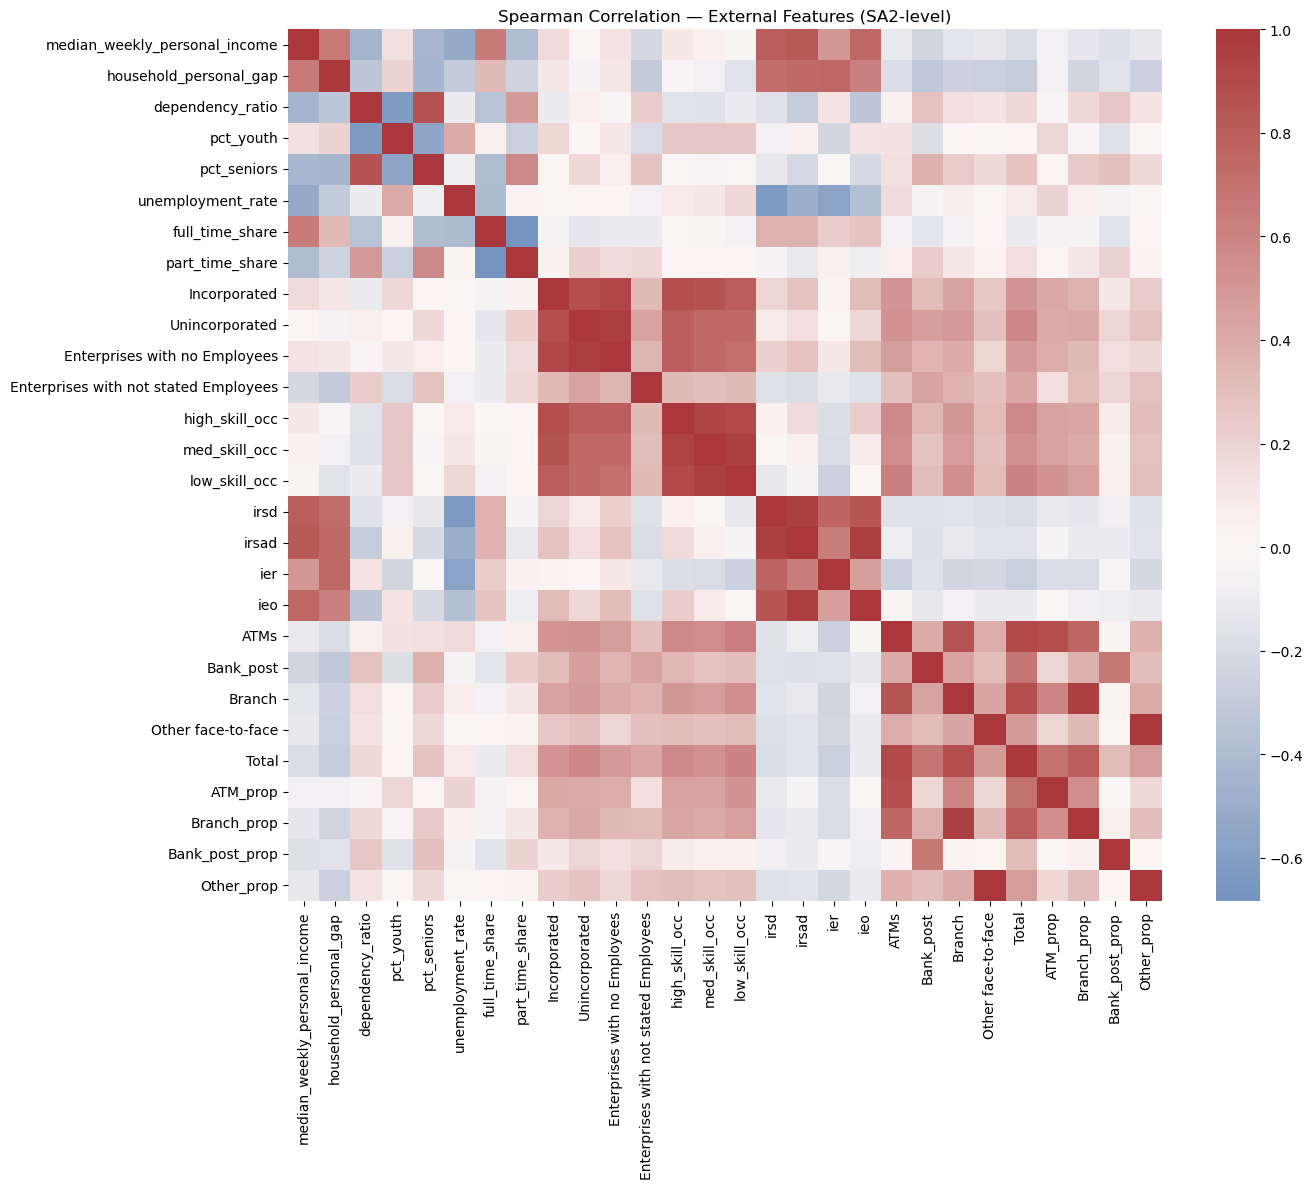

In [21]:
# Plot heatmap
labels = num_cols
plt.figure(figsize=(14,12))
sns.heatmap(np.array(corr_mat), xticklabels=labels, yticklabels=labels, cmap="vlag", center=0)
plt.title("Spearman Correlation — External Features (SA2-level)")
plt.tight_layout(); plt.show()


This SA2-level Spearman map shows three clear clusters. First, a socio-economic axis: higher median personal income is strongly aligned with higher full-time share and high-skill occupations, and with SEIFA advantage (irsad, ier, ieo), while moving in the opposite direction of unemployment, low-skill occupations, SEIFA disadvantage (irsd), and an older age mix (pct_seniors, higher dependency_ratio). Conversely, areas with more part-time work and unemployment tend to be lower-income and more disadvantaged—classic monotonic patterns that Spearman picks up even if not perfectly linear. Second, a business/enterprise structure cluster: Incorporated and skilled-occupation shares co-move with advantage and income, whereas unincorporated / no-employees lean toward the lower-income, higher-unemployment side—consistent with a greater prevalence of micro-enterprises in less advantaged SA2s. Third, a banking access/scale cluster: raw counts of ATMs/Branches/Bank-post/Other and their Total are tightly correlated with population (a size effect). Within that, the _prop variables trade off by construction (e.g., a higher Branch_prop typically means lower ATM_prop/Bank_post_prop), so expect strong negative cross-correlations among the proportions.
Practically, these patterns mean many external features are collinear (e.g., income ↔ SEIFA ↔ skill mix ↔ employment). For modeling merchant fraud rates, either (a) use a regularized or tree-based model that can handle redundancy, or (b) reduce dimensionality (e.g., pick one SEIFA index plus one labour marker) to avoid over-weighting the same latent construct. Also note that correlations here are area-level associations (not causal) and proportions sum to one, which mechanically induces negative links among those banking-channel shares.

## Merge External Dataset with Consumer

In [22]:
# Ensure consistent column names and type before joining
def to_sa2_str(colname, width=9):
    raw = F.upper(F.trim(F.col(colname)))
    digits = F.regexp_replace(raw, r'[^0-9]', '')
    return F.when(digits == "", F.lit(None)).otherwise(F.lpad(digits, width, '0'))

consumer_df  = consumer_df.withColumn("SA2_code", to_sa2_str("SA2_code").cast("string"))
gcp          = gcp.withColumn("SA2_code", to_sa2_str("SA2_code").cast("string"))
wpp          = wpp.drop("_c0") if "_c0" in wpp.columns else wpp
wpp          = wpp.withColumn("SA2_code", to_sa2_str("SA2_code").cast("string"))
apra_seifa   = apra_seifa.withColumn("SA2_code", to_sa2_str("SA2_code").cast("string"))


# Join strictly on the same string column name
consumer_full = (consumer_df
    .join(gcp,        on="SA2_code", how="left")
    .join(wpp,        on="SA2_code", how="left")
    .join(apra_seifa, on="SA2_code", how="left"))

print(f"Consumer rows before join: {consumer_df.count()}")
print(f"Consumer rows after join:  {consumer_full.count()}")

Consumer rows before join: 20111
Consumer rows after join:  20111


In [23]:
# Drop duplicated & unnecessary columns
cols_to_drop = [
    "_c0", "_c0"                # duplicate index column
    "geometry",           # shapefile geometry, not needed for ML
    "SA2_name",           # drop duplicates, we'll keep just one
    "sa2name",            # redundant with SA2_name
    "is_po_box", "geometry",
    "state_name", "state_code", "population",
    "Total", "ATM_prop", "Branch_prop", "Bank_post_prop", "Other_prop"
]

# Remove duplicates from the list (SA2_name appears twice)
cols_to_drop = list(set(cols_to_drop))

consumer_clean = consumer_full.drop(*cols_to_drop)

# Double-check remaining columns
print("Remaining columns after cleaning:")
print(consumer_clean.columns)
print(f"Consumer rows after cleaning:  {consumer_clean.count()}")

Remaining columns after cleaning:
['SA2_code', 'consumer_id', 'transaction_count', 'total_spend', 'unique_merchants', 'avg_spend', 'fraud_prob_avg', 'name', 'address', 'state', 'postcode', 'gender', 'user_id', 'median_weekly_personal_income', 'household_personal_gap', 'dependency_ratio', 'pct_youth', 'pct_seniors', 'unemployment_rate', 'full_time_share', 'part_time_share', 'Incorporated', 'Unincorporated', 'Enterprises with no Employees', 'Enterprises with not stated Employees', 'high_skill_occ', 'med_skill_occ', 'low_skill_occ', 'irsad', 'irsd', 'ier', 'ieo', 'ATMs', 'Bank_post', 'Branch', 'Other face-to-face']
Consumer rows after cleaning:  20111


In [24]:
# Count missing values per column
missing_counts = (
    consumer_clean.select([
        F.count(F.when(F.col(c).isNull(), c)).alias(c)
        for c in consumer_clean.columns
    ])
)

missing_counts.show(truncate=False)

25/10/03 18:18:17 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------+-----------+-----------------+-----------+----------------+---------+--------------+----+-------+-----+--------+------+-------+-----------------------------+----------------------+----------------+---------+-----------+-----------------+---------------+---------------+------------+--------------+-----------------------------+-------------------------------------+--------------+-------------+-------------+-----+----+---+---+----+---------+------+------------------+
|SA2_code|consumer_id|transaction_count|total_spend|unique_merchants|avg_spend|fraud_prob_avg|name|address|state|postcode|gender|user_id|median_weekly_personal_income|household_personal_gap|dependency_ratio|pct_youth|pct_seniors|unemployment_rate|full_time_share|part_time_share|Incorporated|Unincorporated|Enterprises with no Employees|Enterprises with not stated Employees|high_skill_occ|med_skill_occ|low_skill_occ|irsad|irsd|ier|ieo|ATMs|Bank_post|Branch|Other face-to-face|
+--------+-----------+-----------------+--

In [25]:
# Save as a single CSV file (coalesce to 1 partition first)
(consumer_clean
    .coalesce(1)
    .write
    .option("header", True)
    .mode("overwrite")
    .csv("./data/curated/full_consumer_df"))

output_dir = "./data/curated/full_consumer_df"
part_file = glob.glob(f"{output_dir}/part-*.csv")[0]
shutil.move(part_file, "./data/curated/full_consumer_df.csv")
shutil.rmtree(output_dir)